# Sentiment Analysis of Covid-19 Tweets

#  Abstract
Κατά την διάρκεια της πανδημίας, πολλοί χρήστες του Twitter Δημοσιεύουν διάφορα Posts που αποτελούν την γνώμη τους σχετικά με τον Covid-19. Θα ήταν καλό να γνωρίζουμε το συναίσθημα που προκύπτει από το κάθε post, προκειμένου να δούμε κατά πόσο έχει επηρεαστεί η ψυχολογία του εκάστοτε χρήστη.

Τα δεδομένα που χρησιμοποιήθηκαν κατα τις training/validation διαδικασίες μπορεί κανείς να τα βρεί στο Kaggle στο παρακάτω URL:
https://www.kaggle.com/gauravsahani/covid-19-sentiment-analysis-using-spacy/data

Μπορούμε να κατεβάσουμε τα δεδομένα με την παρακάτω command:

$ kaggle kernels output gauravsahani/covid-19-sentiment-analysis-using-spacy -p /path/to/dest


#  Data Processing
Παρακάτω αφού έχουμε κατεβάσει τα δεδομένα απο το Kaggle, διαβάζουμε το csv file το οποίο αφορά τα δεδομένα του Training.
Όπως θα παρατηρήσουμε στο Kaggle τα δεδομένα μας είναι χωρισμένα σε 2 csv αρχεία. Ένα Train και ένα Test.
Έτσι λοιπόν αφού κάνουμε import τις απαραίτητες βιβλιοθήκες που θα χρειαστούμε μπορούμε να διαβάσουμε τα csv.

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.corpus import  wordnet
# nltk.download('wordnet')
from nltk import FreqDist, PorterStemmer, SnowballStemmer, Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import joblib
import time
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn import feature_selection
import plotly.express as px
from sklearn.manifold import TSNE
import plotly.io as pio
pio.renderers.default = "notebook"
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) # gia na exw to plot xwris na to trexw ksana
from tabulate import tabulate

In [2]:
data = pd.read_csv(r"Covid19sentimentAnalysis/Datasets/Corona_NLP_train.csv", encoding='ansi')
print(data.head(5))

   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  


Αφού διαβάσαμε τα δεδομένα απο το CSV αρχείο και τα φέραμε σε ένα DataFrame ακολουθεί η επεξεργασια αυτών και η διερεύνηση για το τι δεδομένα έχουμε.

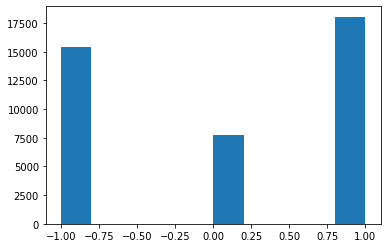

In [3]:
data["Sentiment"] = data["Sentiment"].replace('Extremely Negative', 'Negative', regex=True)

data["Sentiment"] = data["Sentiment"].replace('Extremely Positive', 'Positive', regex=True)

#transform Sentiment to number
#negative=0
#postive=1
#neutral=2
data["Sentiment"]=data["Sentiment"].replace('Negative', -1, regex=True)
data["Sentiment"]=data["Sentiment"].replace('Positive', 1, regex=True)
data["Sentiment"]=data["Sentiment"].replace('Neutral', 0, regex=True)



plt.hist(data["Sentiment"])
plt.show()


Όπως μπορούμε να δούμε για την Class = Negative = -1 έχουμε περίπου 15.500 samples. Ομοίως για τη Class = Positive = 1 έχουμε περίπου 17.500 samples. Τέλος για την Class = Neutral = 0 έχουμε περίπου 7.500 samples.

## Ακολουθεί η διαδικασία του Processing:
Μετά απο πολύ ψάξιμο εντός των δεδομένων παρατήρησα οτι έχουμε κάποιες περίεργες λέξεις και κάποιες λέξεις με απόστροφο. 
Επίσης είναι λογικό σε ένα tweet να βρει κανείς και emojis/emoticons. Όλα αυτά αποθηκεύτηκαν σε κάποια dictionaries με σκοπό να κάνουμε lookups
για να μπρούμε να τα αντικαθιστούμε ή να τα διαγράφουμε.

In [4]:
#short words/apostrophe lookup
contraction_dict1 = {"Â":"","’":"'","Ã":""}
contraction_dict2 = {"Â":"","’":"'","ain't": "are not","'s":" is","aren't": "are not","don't": "do not","Don't":"Do not",
                     "I'll":"I will","Didn't":"Did not","hasn't":"has not","NYC":"New York City","16MAR20":"",
                     "I'd":"I would","I've":"I have","you're":"you are","I'm":"I am","it's":"it is",
                     "#NZ":"","they'll":"they will","they're":"they are","can't":"can not","Y'all":"You All",
                     "I m":"I am","can't":"can not","don t":"do not","I ve":"I have","we're":"we are",
                     "LOL":"lough out loud","lol":"lough out loud","FYI":"For your information","OFC":"Of Course","ofc":"Of Course",
                     "#coronavirÃ¼s":"coronavirus","pls":"please","#stayhomesavelives":"stay home save lives",
                     "hasn't": 'has not',"haven't": 'have not',"he'd": 'he had / he would',"he'd've": 'he would have',
                     "he'll": 'he shall / he will',"he'll've": 'he shall have / he will have',
                     "he's": 'he has / he is',"how'd": 'how did', "how'd'y": 'how do you', "how'll": 'how will',
                     "how's": 'how has / how is', "i'd": 'I had / I would',"i'd've": 'I would have',  "i'll": 'I shall / I will',
                     "i'll've": 'I shall have / I will have',"i'm": 'I am', "i've": 'I have', "isn't": 'is not', "it'd": 'it had / it would',
                     "it'd've": 'it would have', "it'll": 'it shall / it will',
                     "it'll've": 'it shall have / it will have',"it's": 'it has / it is', "let's": 'let us',
                     "ma'am": 'madam', "mayn't": 'may not',
                     "might've": 'might have', "mightn't": 'might not',
                     "mightn't've": 'might not have', "must've": 'must have',"mustn't": 'must not',
                     "mustn't've": 'must not have', "needn't": 'need not',
                     "needn't've": 'need not have', "o'clock": 'of the clock',
                     "oughtn't": 'ought not', "oughtn't've": 'ought not have',
                     "shan't": 'shall not', "sha'n't": 'shall not',
                     "shan't've": 'shall not have', "she'd": 'she had / she would',
                     "she'd've": 'she would have', "she'll": 'she shall / she will',
                     "she'll've": 'she shall have / she will have',
                     "she's": 'she has / she is', "should've": 'should have',
                     "shouldn't": 'should not',"shouldn't've": 'should not have',
                     "so've": 'so have', "so's": 'so as / so is',
                     "that'd": 'that would / that had',"that'd've": 'that would have',
                     "that's": 'that has / that is', "there'd": 'there had / there would',
                     "there'd've": 'there would have', "there's": 'there has / there is',
                     "they'd": 'they had / they would',  "they'd've": 'they would have',
                     "they'll": 'they shall / they will', "they'll've": 'they shall have / they will have',
                     "they're": 'they are',  "they've": 'they have',
                     "to've": 'to have', "wasn't": 'was not',
                     "we'd": 'we had / we would',  "we'd've": 'we would have',
                     "we'll": 'we will', "we'll've": 'we will have',
                     "we're": 'we are', "we've": 'we have',
                     "weren't": 'were not', "what'll": 'what shall / what will',
                     "what'll've": 'what shall have / what will have',
                     "what're": 'what are', "what's": 'what has / what is',
                     "what've": 'what have',"when's": 'when has / when is',
                     "when've": 'when have', "where'd": 'where did',
                     "where's": 'where has / where is',
                     "where've": 'where have', "who'll": 'who shall / who will',
                     "who'll've": 'who shall have / who will have',
                     "who's": 'who has / who is', "who've": 'who have',
                     "why's": 'why has / why is', "why've": 'why have',
                     "will've": 'will have', "won't": 'will not',"won't've": 'will not have',
                     "would've": 'would have',"wouldn't": 'would not',"wouldn't've": 'would not have',
                     "y'all": 'you all', "y'all'd": 'you all would',
                     "y'all'd've": 'you all would have', "y'all're": 'you all are',
                     "y'all've": 'you all have', "you'd": 'you had / you would',
                     "you'd've": 'you would have',"&amp":"and","btc":"bitcoin","irs":"","spx":"","📍":"","✅":""
                     }

emoticons={':)': 'happy', ':‑)': 'happy',
 ':-]': 'happy', ':-3': 'happy',
 ':->': 'happy', '8-)': 'happy',
 ':-}': 'happy', ':o)': 'happy',
 ':c)': 'happy', ':^)': 'happy',
 '=]': 'happy', '=)': 'happy',
 '<3': 'happy', ':-(': 'sad',
 ':(': 'sad', ':c': 'sad',
 ':<': 'sad', ':[': 'sad',
 '>:[': 'sad', ':{': 'sad',
 '>:(': 'sad', ':-c': 'sad',
 ':-< ': 'sad', ':-[': 'sad',
 ':-||': 'sad',
  '😢':'sad'         }

myOwnStopWords={'price':"",
               'store':"",
               'supermarket':"",
               'food':"",
               'grocery':"",
               'people':"",
               'go':"",
               'consumer':"",
                'usdjpy':"", 'gbpusd':"", 'usdcnh':"", 'xauusd':"", 'wti':"", 'spx':"",'iave':"","aiave":""}

Σκοπός δεν είναι να σβήσουμε τα emojis/emoticons αλλά να τα κάνουμε replace με την λέξη που δείχνουν. Με αυτόν τον τρόπο θα μπροούμε να κρατήσουμε το συναίσθημα που προβάλλουν. 

In [5]:
def lookup_dict(text, dictionary):
    if isinstance(text, float) == False and text is not None:
        for word in text.split():
            if word.lower() in dictionary:
                if word.lower() in text.split():
                    text = text.replace(word, dictionary[word.lower()])
        return text

Παρακάτω ακολουθεί η επεξεργασία των δεδομένων, πριν προκύψουν τα τελικά features που θα χρησιμοποιήσει ο Classifier.
Οι ενέργειες που γίνονται είναι:
   1. lookup στα dictionaries που αναφέραμε για την αντικατάσταση ή διαγραφή λέξεων/emojis/emoticons 
   2. Διαγραφή θορύβου, όπως urls, hashtags, mentions, numbers etc.
   3. Tokenization & αφαίρεση stopwords.
   4. Part of speech tagging για να το χρησιμοποιήσουμε στην διαδικασία του Lemmatization.
   5. Lemmatization.
   6. Αποθήκευση των Cleaned/processed data σε DataFrame.

In [6]:
data["OriginalTweet"] = data["OriginalTweet"].apply(lambda x: lookup_dict(x,emoticons))

data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict1))
data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict2))

data['OriginalTweet'] = data['OriginalTweet'].apply(lambda x: ''.join(''.join(s)[:2] for _, s in itertools.groupby(x)))


#to lower case
data['OriginalTweet']  = data['OriginalTweet'].str.lower()

#remove numbers
data["OriginalTweet"] = data["OriginalTweet"].replace('[0-9]', '', regex=True)

#remove mentions
data["OriginalTweet"] = data["OriginalTweet"].replace('@([a-zA-Z0-9_]{1,50})', '', regex=True)

#remove hashtags
data["OriginalTweet"] = data["OriginalTweet"].replace('#', '', regex=True)

#remove urls
data["OriginalTweet"] = data["OriginalTweet"].replace('http\S+', '', regex=True)

# # #remove all remaining bad chars
data["OriginalTweet"]=data["OriginalTweet"].replace('[^\\w\\s]', '', regex=True)

data["OriginalTweet"]=data["OriginalTweet"].replace("Â", "", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("â", "a", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("nz", "", regex=True)
data['OriginalTweet']  = data['OriginalTweet'].str.strip()


data["OriginalTweet"]=data["OriginalTweet"].replace("_", "", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("   ", " ", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("  ", " ", regex=True)

data['OriginalTweet']  = data['OriginalTweet'].str.strip()
data["OriginalTweet"]=data["OriginalTweet"].replace("coronavir¼", "coronavirus", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("pmmodi", "", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("amp", "and", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("btc", "bitcoin", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("hand", "", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].fillna(0)

data['OriginalTweet']  = data['OriginalTweet'].str.strip()

#Tokenize the tweets
tokenized_tweets = data["OriginalTweet"].apply(lambda x: x.split())

#remove stopword(for example and,to at etc)
stop_words = set(stopwords.words('english'))
tokenized_tweets = tokenized_tweets.apply(lambda x: [word for word in x if not word in stop_words])

#Stemming the words
# stemmer = PorterStemmer()#language='english'
# tokenized_tweets= tokenized_tweets.apply(lambda x: [stemmer.stem(i) for i in x])

def get_pos( word ):
    w_synsets = wordnet.synsets(word)

    pos_counts = nltk.Counter()
    pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )

    most_common_pos_list = pos_counts.most_common(3)
    return most_common_pos_list[0][0]
#get the lemma
lemmatizer = WordNetLemmatizer()

tokenized_tweets = tokenized_tweets.apply(lambda x: [lemmatizer.lemmatize(i,get_pos( i )) for i in x])

tokenized_tweets = tokenized_tweets.apply(lambda x: [word for word in x if len(word)>2 or word=='go'])


#Joining the tokenized tweets
for i in range(len(tokenized_tweets)):
    tokenized_tweets[i] = ' '.join(tokenized_tweets[i])
data["OriginalTweet"] = tokenized_tweets


data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lookup_dict(x,myOwnStopWords))
all_words = []
for line in list(data['OriginalTweet']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())



data["OriginalTweet"]=data["OriginalTweet"].replace("  ", " ", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace(" +", " ", regex=True)
data['OriginalTweet']  = data['OriginalTweet'].str.strip()
print(Counter(all_words).most_common(10))
Y = data["Sentiment"]
print(data.head(5))

[('covid', 21758), ('coronavirus', 17986), ('shop', 5103), ('get', 4461), ('need', 3536), ('online', 3420), ('buy', 3348), ('pandemic', 3167), ('time', 3106), ('work', 2981)]
   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet  Sentiment  
0                                                             0  
1  advice talk neighbour family exchange phone nu...          1  
2  coronavirus australia woolworth give elderly d...          1  
3  stock one empty please panic enough everyone t...          1  
4  ready covid outbreak paranoid stock litteraly ...         -1  


Αφού τα επεξεργαστήκαμε, ακολουθεί η διαδικασία του feature selection & feature extraction.
Θα χρησιμοποιήσουμε τη γνωστή TF-IDF διαδικασία, που έχει να κάνει με frequency των λέξεων/tokens στο Dataset για να μπορέσουμε να κάνουμε extract κάποια Features
και να καταλήξουμε στο γνωστό Bag of Words. 
Χρησιμοποιούμε επίσης και unigrams & bi-grams. 
Αυτό το κάνουμε γιατί μερικά Features θα είχαν πιο πολύ νόημα όσον αφορά το συναίσθημα, εάν αποτελλούνται απο 2 tokens μαζί (bigrams).
Για παράδειγμα:
Πρόταση: 'I don't like'
  1. unigrams: I, do, not, like
  2. bi-grams: I do, do not, not like
Όπως βλέπουμε η λέξη Like απο μόνη της δείχνει συνήθως θετικό συναίσθημα ένω με την λέξη Not μπροστά δείχνει αρνητικό.

In [7]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_features=20000,ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(data["OriginalTweet"])
print(tfidf.toarray().shape)

(41157, 20000)


όπως βλέπουμε έχουμε πάρα πολλές διαστάσεις να διαχειριστούμε και αυτό είναι πρόβλημα τόσο για την απόδοση του Classifier όσο και για τον χρόνο train/validation αλλά και prediction.


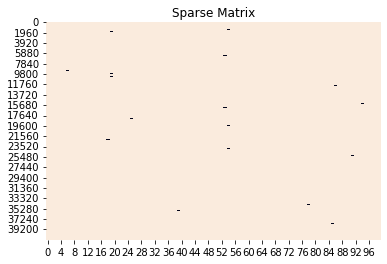

In [8]:
sns.heatmap(tfidf.todense()[:,np.random.randint(0,tfidf.shape[1],100)]==0,vmin=0,vmax=1,cbar=False).set_title('Sparse Matrix')
plt.show()

Απο το παραπάνω plot μπορούμε να δούμε οτι τα Feature μας είναι πολύ αρεά μεταξύ τους Και θα πρέπει να μειωθούν, ώστε να μειώσουμε και τις διαστάσεις. Για να το πετύχουμε αυτό θα χρησιμοποιήσουμε την Chi-square στατιστική μέθοδο, η οποία λαμβάνει υπόψιν της την ανεξαρτησία των παρατηρήσεων. 
Πρακτικά μέσω αυτής της μεθόδου, έχουμε ως στόχο να διακρίνουμε features τα οποία συσχετίζονται πιο πολύ με κάποια κλάση. 


In [9]:
X_names = tfidf_vectorizer.get_feature_names_out()
p_value_limit = 0.95
#this feature selection is ranking features with respect to their usefulness and is not used to make statements about statistical dependence or independence of variables.
features = pd.DataFrame()
for cat in np.unique(data["Sentiment"]):
    chi2, p = feature_selection.chi2(tfidf,data["Sentiment"]==cat)#chi2(tfidf,data["Sentiment"]==cat)
    features = features.append(pd.DataFrame({"feature":X_names,"score":1-p,"Y":cat}))
    features = features.sort_values(["Y","score"],ascending=[True,False])

    features = features[features['score']>p_value_limit]

X_scores = features["score"].unique().tolist()
X_names = features["feature"].unique().tolist()

# praktika h Chi^2 einai
# alpha = 1.0 - prob
# if p <= alpha:
#     print('Dependent (reject H0)')
# else:
#     print('Independent (fail to reject H0)')

for cat in np.unique(data["Sentiment"]):
    print("# {}:".format(cat))
    print(" . selected features:", len(features[features["Y"]==cat]))
    print(" . top features:",",".join(features[features["Y"]==cat]["feature"].values[:20]))
    # print(" . top features scores:",",".join(str(features[features["Y"]==cat]["score"].values[:10])))
    print(" ")

# -1:
 . selected features: 895
 . top features: bad,buy,crisis,fear,oil,panic,panic buy,sanitizer,scam,stop,covid crisis,kill,help,low,die,warn,selfish,stop panic,shortage,coronavirus crisis
 
# 0:
 . selected features: 645
 . top features: toiletpaper,panic,like,demand,help,crisis,panic buy,coronavirus,stop,safe,thank,coronavirus toiletpaper,support,behavior,great,impact,retail closure,care,low,free
 
# 1:
 . selected features: 780
 . top features: best,crisis,free,great,help,like,panic,panic buy,safe,sanitizer,support,thank,love,friend,care,scam,thanks,stay safe,hero,share
 


(41157, 1685)


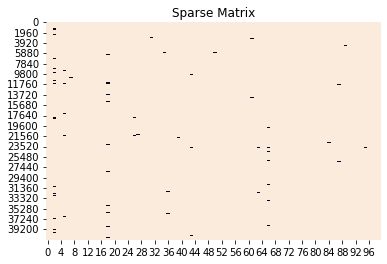

In [10]:
tfidf_vectorizer2 = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
tfidf_new = tfidf_vectorizer2.fit_transform(data["OriginalTweet"])
joblib.dump(tfidf_vectorizer2,'vectorizer.sav') #save the BoW model for future work
print(tfidf_new.toarray().shape)
dic_vocab = tfidf_vectorizer2.vocabulary_

sns.heatmap(tfidf_new.todense()[:,np.random.randint(0,tfidf_new.shape[1],100)]==0,vmin=0,vmax=1,cbar=False).set_title('Sparse Matrix')
plt.show()

Μπορούμε να παρατηρήσουμε οτι τα Features έγιναν λιγότερο αρεά και μειώθηκαν συμαντικά οι διαστάσεις.
Έτσι είμαστε έτοιμοι για την διαδικασία του train/validation. 

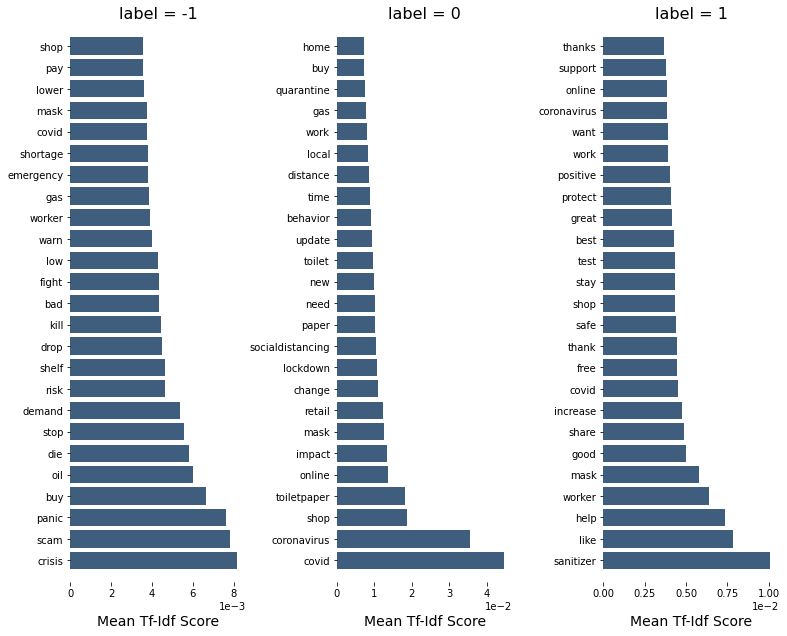

In [11]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    # for cat in np.unique(data["Sentiment"]):
    #     top_featstmp = features[features["Y"]==cat]["feature"].values[:top_n]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.5, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)
def top_feats_by_class(Xtr, y, features, min_tfidf=0.5, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs
dfs = top_feats_by_class(tfidf_new, Y, tfidf_vectorizer2.get_feature_names_out(), min_tfidf=0.5, top_n=25)
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

plot_tfidf_classfeats_h(dfs)

Στο παραπάνω Plot βλέπουμε τα top 25 features με βάση το tf-idf score τους μέσα στο Dataset.
Έτσι πρακτικά μπορούμε να πούμε οτι οι λέξεις όπως Best, like, good κλπ έχουν αρκετή επιρροή στο αν ένα text θα κατηγοριοποιηθεί ως Positive (class label 1). Αντίθετα λέξεις όπως kill ,scam,panic κλπ θα μας κατηγοροποιήσουν το text σε Negative(-1). Ομοίως και για τα Neutrals, όπου εκει βλέπουμε λέξεις που δεν βγάζουν κάποιο συναίσθημα απο μόνες τους και δεν προσδίδουν κάποια σημασία σε αυτό.  Όπως το distance ή το toiletpaper.
Μπορούμε όμως να διακρίνουμε και Features όπως το covid που είναι κοινό στις κλάσεις, αυτό θα μπορούσε να μας πει κάτι σχετικά με την παρουσιά διακριτικών στα features ανάμεσα στις κλάσεις. Δηλαδή δεν μας χωρίζουν το text στις κλάσεις με ξεκάθαρο τρόπο.
Προφανώς αυτά τα Features είναι τα top 25, θα μπορούσαμε να τα δούμε και όλα, όπου εκεί σε συνδιασμό με bi-grams, ίσως αυτές οι κοινές λέξεις να μπορούσαν να διακριτικοποιήσουν το κείμενο.

In [12]:
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(tfidf_new, Y, test_size=0.25,shuffle=True,random_state=0)


clf2 = naive_bayes.ComplementNB(alpha=0.70001).fit(X_train2,y_train2)
y_pred2 = clf2.predict(X_test2)
predicted_prob2 = clf2.predict_proba(X_test2)
m_confusion_test = metrics.confusion_matrix(y_test2, y_pred2)
print("NB")
print(pd.DataFrame(data = m_confusion_test , columns=['Predicted -1', 'Predicted 0','Predicted 1'],index=['Actual -1','Actual 0','Actual 1']))
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred2))
print(metrics.classification_report(y_pred2,y_test2))

clf1 = svm.SVC(kernel='rbf',C=1.5,gamma='scale',probability=True).fit(X_train2,y_train2)
y_pred = clf1.predict(X_test2)
predicted_prob1 = clf1.predict_proba(X_test2)
m_confusion_test = metrics.confusion_matrix(y_test2, y_pred)
print("SVM RBF")
print(pd.DataFrame(data = m_confusion_test , columns=['Predicted -1', 'Predicted 0','Predicted 1'],index=['Predicted -1', 'Predicted 0','Predicted 1']))
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred))
print(metrics.classification_report(y_pred,y_test2))

clf3 = LogisticRegression(multi_class='multinomial', solver='newton-cg',C=10,max_iter=200).fit(X_train2,y_train2)
y_pred3 = clf3.predict(X_test2)
predicted_prob3 = clf3.predict_proba(X_test2)
m_confusion_test = metrics.confusion_matrix(y_test2, y_pred3)
print("Logistic Regression")
print(pd.DataFrame(data = m_confusion_test , columns=['Predicted -1', 'Predicted 0','Predicted 1'],index=['Predicted -1', 'Predicted 0','Predicted 1']))
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred3))
print(metrics.classification_report(y_pred3,y_test2))

for clf, label in zip([clf1, clf2,clf3],
                      ['SVM',
                       'Naive Bayes',
                       'Logistic Regression'
                       ]):

    scores = model_selection.cross_val_score(clf, X_train2, y_train2,
                                             cv=3, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.3f) [%s]"
          % (scores.mean(), scores.std(), label))

NB
           Predicted -1  Predicted 0  Predicted 1
Actual -1          3028          322          484
Actual 0            403         1101          397
Actual 1            605          425         3525
Accuracy: 0.7438289601554907
              precision    recall  f1-score   support

          -1       0.79      0.75      0.77      4036
           0       0.58      0.60      0.59      1848
           1       0.77      0.80      0.79      4406

    accuracy                           0.74     10290
   macro avg       0.71      0.72      0.71     10290
weighted avg       0.75      0.74      0.74     10290

SVM RBF
              Predicted -1  Predicted 0  Predicted 1
Predicted -1          3124          259          451
Predicted 0            234         1394          273
Predicted 1            451          328         3776
Accuracy: 0.8060252672497571
              precision    recall  f1-score   support

          -1       0.81      0.82      0.82      3809
           0       0.73      

Παραπάνω βλέπουμε και τις accuracies μετά απο ένα KFold Corss Validation (K=3) για SVM,Naive Bayes και Logistic Regression αντίστοιχα.
Η επιλογή των Hyper-parameters των μοντέλων επιλέχθηκαν μετά απο την διαδικασία του GridSearchCV το οποίο κάνει ταυτόχρονα και Cross-Validation.

# Metrics

Ας δούμε τι σημαίνουν τα metrics που θα χρησιμοποιήσουμε για την αξιολόγηση των μοντέλων μας.
Για να γίνουν κατανοητές οι παρακάτω μετρικές θα πρέπει πρώτα να ορίσουμε κάποιους όρους τους οποίους χρησιμοποιούν για τους υπολογισμούς.
1. True positive (TP): υποδηλώνει πόσα δείγματα που ήταν πραγματικά θετικά πρόβλεψε σωστά το μοντέλο μας.
2. True Negative (TN): υποδηλώνει πόσα δείγματα που ήταν πραγματικά αρνητικά πρόβλεψε σωστά το μοντέλο μας.
3. False Positive (FP): υποδηλώνει πόσα δείγματα που ήταν πραγματικά αρνητικά πρόβλεψε λανθασμένα το μοντέλο μας. Δηλαδή τα πρόβλεψε σας θετικά ενώ ηταν αρνητικά. 
4. False Negative (FN): υποδηλώνει πόσα δείγματα που ήταν πραγματικά θετικά πρόβλεψε λανθασμένα το μοντέλο σας.Δηλαδή τα πρόβλεψε σας αρνητικά ενώ ηταν θετικά.

Τα παραπάνω μπορούν να προκύψουν απο τον confusion matrix που θα παρουσιάσουμε παρακάτω. 

## Accuracy
Αποτελεί ένα τρόπο μέτρησης για κάθε μοντέλο. Είναι η ακρίβεια του μοντέλου και η 
δυνατότητα να προβλέψει σωστά κάθε κλάση. Προκύπτει από το άθροισμα των σωστών 
προβλέψεων (TP) διά όλα τα samples του validation/test set. <br>
$ Accuracy = \frac{TP}{All Samples} $

## Recall
Το Recall (ανάκληση) αποτελεί τρόπο μέτρησης απόδοσης του μοντέλου. Αναφέρεται 
στο ποσοστό των συνολικών σχετικών αποτελεσμάτων που ταξινομήθηκαν σωστά από 
τον αλγόριθμό σας. <br>
$ Recall = \frac{TP}{TP + FN}$

## Precision
Το Precision (ακρίβεια) αποτελεί τρόπο μέτρησης απόδοσης του μοντέλου. Αναφέρεται 
στο ποσοστό των αποτελεσμάτων που μας ενδιαφέρουν. <br>
$ Precision = \frac{TP}{TP + FP}$

## F1-score
Αποτελεί ένα χρήσιμο τρόπο μέτρησης ιδίως σε σώμα δεδομένων που εμπεριέχει άνιση 
κατανομή κλάσεων. <br>
$ F1 = 2 * \frac{Precision * Recall}{Precision + Recall} $ <br>
Για την αξιολόγηση των μοντέλων μας θα χρησιμοποιήσουμε το macro F1 που αποτελεί ένα μέσο όρο των F1 για κάθε κλάση. 

## Area Under Curve (AUC)
Αποτελεί ένα είδος μέτρησης αποδοτικότητας του εκπαιδευμένου μοντέλου. Πρακτικά 
όσο πιο μεγάλη είναι η τιμή της AUC(Area Under Curve), δηλαδή όσο πιο ψηλά είναι η 
καμπύλη, τόσο πιο αποδοτικό είναι το μοντέλο. Δηλαδή για παράδειγμα είναι σε θέση να προβλέπει τα 0 
ως 0 και τα 1 ως 1. 

#  SVM metrics

In [13]:
precissions=list()
recalls=list()
accs=list()
f1scores=list()

Accuracy: 0.81
macro F1: 0.79
Auc: 0.91
Recall: 0.79
Precission: 0.79
Detail:


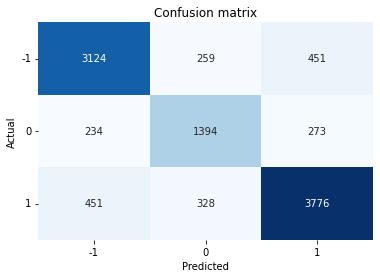

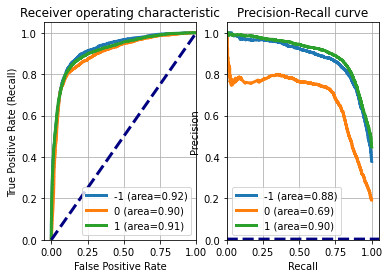

In [14]:

classes = np.unique(y_test2)
y_test_array = pd.get_dummies(y_test2, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test2, y_pred)
fscore = metrics.f1_score(y_test2, y_pred, average='macro')
auc = metrics.roc_auc_score(y_test2, predicted_prob1,
                            multi_class="ovr")
prec=metrics.precision_score(y_test2, y_pred,average='macro')
rec = metrics.recall_score(y_test2, y_pred, average='macro')
print("Accuracy:",  round(accuracy,2))
print("macro F1:",  round(fscore,2))
print("Auc:", round(auc,2))
print("Recall:", round(rec,2))
print("Precission:", round(prec,2))
print("Detail:")

accs.append(accuracy)
f1scores.append(fscore)
precissions.append(prec)
recalls.append(rec)
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test2, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=classes,
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],
                                             predicted_prob1[:,i])
    ax[0].plot(fpr, tpr, lw=3,
               label='{0} (area={1:0.2f})'.format(classes[i],
                                                  metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05],
          xlabel='False Positive Rate',
          ylabel="True Positive Rate (Recall)",
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test_array[:,i], predicted_prob1[:,i])
    ax[1].plot(recall, precision, lw=3,
               label='{0} (area={1:0.2f})'.format(classes[i],
                                                  metrics.auc(recall, precision))
               )

ax[1].plot(thresholds, color='navy', lw=3, linestyle='--')    
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall',
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()
# print(thresholds)

# Naive Bayes metrics

Accuracy: 0.74
macro F1: 0.71
Auc: 0.89
Recall: 0.71
Precission: 0.72
Detail:


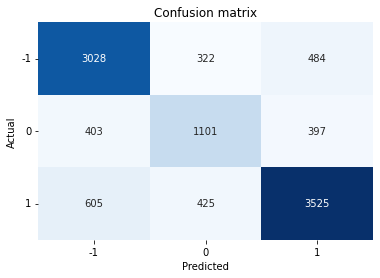

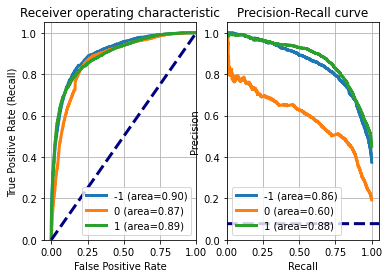

In [15]:
classes = np.unique(y_test2)
y_test_array = pd.get_dummies(y_test2, drop_first=False).values
# y_pred2 = clf2.predict(X_test2)
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test2, y_pred2)
fscore = metrics.f1_score(y_test2, y_pred2, average='macro')
auc = metrics.roc_auc_score(y_test2, predicted_prob2,
                            multi_class="ovr")
prec=metrics.precision_score(y_test2, y_pred2,average='macro')
rec = metrics.recall_score(y_test2, y_pred2,average='macro')
print("Accuracy:",  round(accuracy,2))
print("macro F1:",  round(fscore,2))
print("Auc:", round(auc,2))
print("Recall:", round(rec,2))
print("Precission:", round(prec,2))
print("Detail:")

accs.append(accuracy)
f1scores.append(fscore)
precissions.append(prec)
recalls.append(rec)
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test2, y_pred2)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=classes,
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],
                                             predicted_prob2[:,i])
    ax[0].plot(fpr, tpr, lw=3,
               label='{0} (area={1:0.2f})'.format(classes[i],
                                                  metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05],
          xlabel='False Positive Rate',
          ylabel="True Positive Rate (Recall)",
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test_array[:,i], predicted_prob2[:,i])
    ax[1].plot(recall, precision, lw=3,
               label='{0} (area={1:0.2f})'.format(classes[i],
                                                  metrics.auc(recall, precision))
               )
ax[1].plot(thresholds, color='navy', lw=3, linestyle='--')   
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall',
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Logistic Regression metrics

Accuracy: 0.81
macro F1: 0.79
Auc: 0.91
Recall: 0.8
Precission: 0.79
Detail:


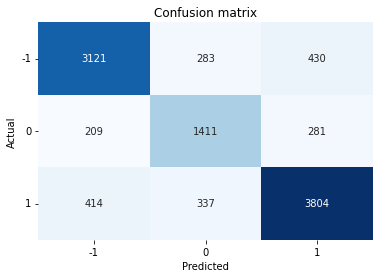

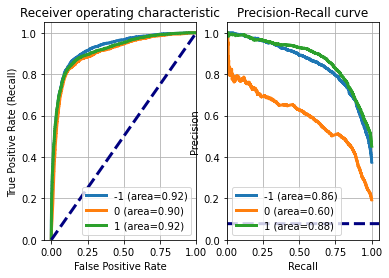

In [16]:
classes = np.unique(y_test2)
y_test_array = pd.get_dummies(y_test2, drop_first=False).values
# y_pred3 = clf3.predict(X_test2)
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test2, y_pred3)
fscore = metrics.f1_score(y_test2, y_pred3, average='macro')
auc = metrics.roc_auc_score(y_test2, predicted_prob3,
                            multi_class="ovr")

prec=metrics.precision_score(y_test2, y_pred3,average='macro')
rec = metrics.recall_score(y_test2, y_pred3,average='macro')
print("Accuracy:",  round(accuracy,2))
print("macro F1:",  round(fscore,2))
print("Auc:", round(auc,2))
print("Recall:", round(rec,2))
print("Precission:", round(prec,2))
print("Detail:")

accs.append(accuracy)
f1scores.append(fscore)
precissions.append(prec)
recalls.append(rec)
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test2, y_pred3)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=classes,
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],
                                             predicted_prob3[:,i])
    ax[0].plot(fpr, tpr, lw=3,
               label='{0} (area={1:0.2f})'.format(classes[i],
                                                  metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05],
          xlabel='False Positive Rate',
          ylabel="True Positive Rate (Recall)",
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test_array[:,i], predicted_prob2[:,i])
    ax[1].plot(recall, precision, lw=3,
               label='{0} (area={1:0.2f})'.format(classes[i],
                                                  metrics.auc(recall, precision))
               )
ax[1].plot(thresholds, color='navy', lw=3, linestyle='--')   
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall',
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

Απο τα παραπάνω Plots μπορούμε να παρατηρήσουμε οτι ο SVM με RBF kernel και το Logistic Regression μπορούν καλύτερα να κάνουν generalize τα δεδομένα μας και απέδωσαν σχετικά όμοια. Όμως αν κανείς λάβει υπόψιν του τα precission και Recall για τον κάθε classifier, τότε θα παρατηρήσει οτι ο SVM μπορεί να κάνει καλύτερες προβλέψεις. 

Ας αποθηκεύσουμε τα trained models για μελλοντική χρήση.

In [17]:
filenameNB = 'nb.sav'
joblib.dump(clf2, filenameNB)
filenameSVC = 'SVC.sav'
joblib.dump(clf1, filenameSVC)
filenameLR = 'LR.sav'
joblib.dump(clf3, filenameLR)

['LR.sav']

Στον παρακάτω πίνακα φαίνονται τα metrics για κάθε μοντέλο. 

In [17]:


info = {'Models': ['SVM RBF', 'Naive Bayes', 'Logistic Regression'], 'macro-F1 scores': f1scores, 'avg Accuracies': accs,
       'Precision':precissions,'Recall':recalls}
print(tabulate(info,headers='keys',tablefmt='fancy_grid',showindex=True))

╒════╤═════════════════════╤═══════════════════╤══════════════════╤═════════════╤══════════╕
│    │ Models              │   macro-F1 scores │   avg Accuracies │   Precision │   Recall │
╞════╪═════════════════════╪═══════════════════╪══════════════════╪═════════════╪══════════╡
│  0 │ SVM RBF             │          0.789894 │         0.806025 │    0.787653 │ 0.792364 │
├────┼─────────────────────┼───────────────────┼──────────────────┼─────────────┼──────────┤
│  1 │ Naive Bayes         │          0.714535 │         0.743829 │    0.715357 │ 0.714273 │
├────┼─────────────────────┼───────────────────┼──────────────────┼─────────────┼──────────┤
│  2 │ Logistic Regression │          0.793403 │         0.810107 │    0.790286 │ 0.797133 │
╘════╧═════════════════════╧═══════════════════╧══════════════════╧═════════════╧══════════╛


Όπως βλέπουμε απ οτον πίνακα SVM & Logistic Regression έχουν σχεδόν την ίδια απόδοση. Δεδομένου όμως τα Precission & Recall σχετικά καλύτερη αλλά οχι αισθητή απόδοση έχει ο SVM.  

# Διαδικασία Test & Prediction σε unknown Data

Θα ακολουθήσουμε την ίδια διαδικασία processing που ακολουθήσαμε για το training.

In [18]:
#read the test csv file
dataTest = pd.read_csv(r"Covid19sentimentAnalysis/Datasets/Corona_NLP_test.csv", encoding='ansi')
dataTest["Sentiment"] = dataTest["Sentiment"].replace('Extremely Negative', 'Negative', regex=True)

dataTest["Sentiment"] = dataTest["Sentiment"].replace('Extremely Positive', 'Positive', regex=True)
dataTest["Sentiment"]=dataTest["Sentiment"].replace('Negative', -1, regex=True)
dataTest["Sentiment"]=dataTest["Sentiment"].replace('Positive', 1, regex=True)
dataTest["Sentiment"]=dataTest["Sentiment"].replace('Neutral', 0, regex=True)
#to lower case
dataTest["OriginalTweet"] = dataTest["OriginalTweet"].apply(lambda x: lookup_dict(x,emoticons))

dataTest['OriginalTweet']=dataTest['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict1))
dataTest['OriginalTweet']=dataTest['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict2))

dataTest['OriginalTweet'] = dataTest['OriginalTweet'].apply(lambda x: ''.join(''.join(s)[:2] for _, s in itertools.groupby(x)))


#to lower case
dataTest['OriginalTweet']  = dataTest['OriginalTweet'].str.lower()

#remove numbers
dataTest["OriginalTweet"] = dataTest["OriginalTweet"].replace('[0-9]', '', regex=True)

#remove mentions
dataTest["OriginalTweet"] = dataTest["OriginalTweet"].replace('@([a-zA-Z0-9_]{1,50})', '', regex=True)

#remove hashtags
dataTest["OriginalTweet"] = dataTest["OriginalTweet"].replace('#', '', regex=True)

#remove urls
dataTest["OriginalTweet"] = dataTest["OriginalTweet"].replace('http\S+', '', regex=True)

# # #remove all remaining bad chars
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace('[^\\w\\s]', '', regex=True)

dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("Â", "", regex=True)
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("â", "a", regex=True)
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("nz", "", regex=True)
dataTest['OriginalTweet']  = dataTest['OriginalTweet'].str.strip()


dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("_", "", regex=True)
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("   ", " ", regex=True)
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("  ", " ", regex=True)
dataTest['OriginalTweet']  = dataTest['OriginalTweet'].str.strip()
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("coronavir¼", "coronavirus", regex=True)
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("pmmodi", "", regex=True)
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("amp", "and", regex=True)
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].fillna(0)

dataTest['OriginalTweet']  = dataTest['OriginalTweet'].str.strip()
#Tokenize the tweets
tokenized_tweets = dataTest["OriginalTweet"].apply(lambda x: x.split())

#remove stopword(for example and,to at etc)
stop_words = set(stopwords.words('english'))
tokenized_tweets = tokenized_tweets.apply(lambda x: [word for word in x if not word in stop_words])

# stemmer = PorterStemmer()#language='english'
# tokenized_tweets= tokenized_tweets.apply(lambda x: [stemmer.stem(i) for i in x])

lemmatizer = WordNetLemmatizer()
tokenized_tweets = tokenized_tweets.apply(lambda x: [lemmatizer.lemmatize(i,get_pos( i )) for i in x])

tokenized_tweets = tokenized_tweets.apply(lambda x: [word for word in x if len(word)>2 or word=='go'])
# tokenized_tweets= tokenized_tweets.apply(lambda x: [stemmer.stem(i) for i in x])

#Joining the tokenized tweets
for i in range(len(tokenized_tweets)):
    tokenized_tweets[i] = ' '.join(tokenized_tweets[i])
dataTest["OriginalTweet"] = tokenized_tweets


dataTest['OriginalTweet']=dataTest['OriginalTweet'].apply(lambda x:lookup_dict(x,myOwnStopWords))
all_words = []
for line in list(dataTest['OriginalTweet']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())


dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("  ", " ", regex=True)

Για το Feature extraction θα χρησιμοποιήσουμε το ίδιο μοντέλο BoW (TF-IDF) που χρησιμοποιήσαμε παραπάνω στο training.

In [19]:
tfidf= tfidf_vectorizer2.transform(dataTest["OriginalTweet"])

Ας πάμε να δούμε τα predictions και τους χρόνους που χρειάζεται ένας αλγόριθμος για να κάνει το predict.

SVM
Accuracy: 0.7733017377567141
              precision    recall  f1-score   support

          -1       0.80      0.80      0.80      1627
           0       0.67      0.63      0.65       659
           1       0.79      0.81      0.80      1512

    accuracy                           0.77      3798
   macro avg       0.75      0.75      0.75      3798
weighted avg       0.77      0.77      0.77      3798

Duration: 8.31763243675232
NB
Accuracy: 0.7306477093206951
              precision    recall  f1-score   support

          -1       0.78      0.77      0.78      1657
           0       0.59      0.53      0.56       686
           1       0.73      0.78      0.76      1455

    accuracy                           0.73      3798
   macro avg       0.70      0.69      0.70      3798
weighted avg       0.73      0.73      0.73      3798

Duration: 0.002012968063354492
LR
Accuracy: 0.7848867825171143
              precision    recall  f1-score   support

          -1       0.80     

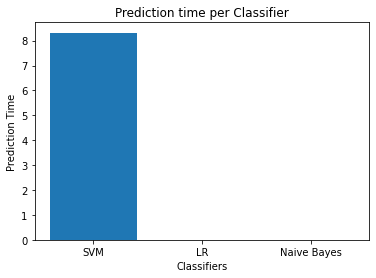

In [20]:
# clf3 = joblib.load('Covid19sentimentAnalysis/savedModels/LR.sav')
# tfidf_vectorizer = joblib.load('Covid19sentimentAnalysis/savedModels/vectorizer.sav')
# tfidf= tfidf_vectorizer.transform(data["OriginalTweet"])
start = time.time()
y_pred= clf1.predict(tfidf)
probas = clf1.predict_proba(tfidf)
duration = time.time() - start
print("SVM")
print("Accuracy:",metrics.accuracy_score(dataTest["Sentiment"], y_pred))
print(metrics.classification_report(y_pred,dataTest["Sentiment"]))
print("Duration: "+str(duration))

start2 = time.time()
y_pred2= clf2.predict(tfidf)
duration2 = time.time() - start2
print("NB")
print("Accuracy:",metrics.accuracy_score(dataTest["Sentiment"], y_pred2))
print(metrics.classification_report(y_pred2,dataTest["Sentiment"]))
print("Duration: "+str(duration2))

start3 = time.time()
y_pred3= clf3.predict(tfidf)
probas3 = clf3.predict_proba(tfidf)
# probs=list()
# for i in probas3:
#     probs.append(np.max(i))
# # print(probs)
duration3 = time.time() - start3
print("LR")
print("Accuracy:",metrics.accuracy_score(dataTest["Sentiment"], y_pred3))
print(metrics.classification_report(y_pred3,dataTest["Sentiment"]))
print("Duration: "+str(duration3))

durations = [duration,duration2,duration3]
models = ['SVM', 'LR','Naive Bayes']

plt.bar(models, durations)

plt.xlabel('Classifiers')

plt.ylabel('Prediction Time')
 
plt.title('Prediction time per Classifier')
 
plt.show()

Δεδομένου των παραπάνω classification reports αλλά και τις αποδόσεις των μοντέλων κατα το training/validation παρατηρούμε οτι τα 2 best models είναι ο SVM και το Logistic Regression με ελάχιστα καλύτερη απόδοση ο SVM. Αν όμως αναλογιστούμε οτι το εκάστοτε μοντέλο θα γίνει deploy σε κάποιο παραγωγικό περιβάλλον μας ενδιαφέρει και το μέγεθός του όπως και η ταχύτητα κατα το prediction. Άρα θα μπορούσε να πει κανείς οτι με βάση όλα αυτά το καλύτερο μοντέλο είναι αυτό του Logistic Regression, καθώς κάνει και λιγότερο χρόνο κατα το prediction. 

Ας δούμε την κατανομή των Features με βάση την πιθανότητα να ανοίκει σε κάποια κλάση.
Για να το πετύχουμε αυτό θα φέρουμε στις 2 διαστάσεις τα δεδομένα με την βοήθεια της μεθόδου t-SNE. 
Αυτή η μέθοδος είναι ένα εργαλείο για την οπτικοποίηση δεδομένων υψηλών διαστάσεων. Μετατρέπει τις ομοιότητες μεταξύ σημείων δεδομένων σε κοινές πιθανότητες και προσπαθεί να ελαχιστοποιήσει την απόκλιση Kullback-Leibler μεταξύ των κοινών πιθανοτήτων των low-dimensional embedding και των δεδομένων υψηλής διάστασης.

#  For LR
Θα χρησιμοποιήσουμε τα predicted probabilities που προκύπτουν απο το LR για το κατα πόσο είναι σίγουρο το μοντέλο οτι ενα tweet ανοίκει σε κάποια κλάση.

In [21]:


tsne = TSNE(n_components=2,learning_rate='auto',init='random')
# pca= PCA(n_components=1)
X_embedded  = tsne.fit_transform(tfidf)
df = pd.DataFrame(columns=['tsne_1','tsne_2','probas','tweet','Sentiment'])
df['tsne_1'] = X_embedded[:, 0]
# df['pca'] = X_embedded[:, 0]
df['tsne_2'] = X_embedded[:, 1]
df['probas'] = pd.DataFrame(probas3)
df['tweet'] = dataTest['OriginalTweet']
df['Sentiment'] = dataTest['Sentiment']
    # print(df.shape)
    # print(df['tsne_1'].head(2))
fig = px.scatter(df, x='probas', y='tsne_1', hover_name= 'tweet',color='Sentiment',size_max=45
                     , template='plotly_white', title='unigram-Bigram similarity and frequency per Sentiment from LR', labels={'words': 'Avg. Length<BR>(words)'}
                     , color_continuous_scale=px.colors.sequential.Sunsetdark)
fig.update_traces(marker=dict(line=dict(width=1, color='Gray')))
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
# fig.show()

iplot(fig)
# fig.write_html('scatter.html')

Παραπάνω βλέπουμε τις συσχετίσεις των features που χρησιμοποιήθηκαν για το prediction σε συνδιασμό με την predicted πιθανότητα (άξονας X ) απο τον classifier να ανοίκει κάποιο tweet σε μια απο τις 3 κλάσεις μας. Παρατηρούμε οτι στα αριστερά με μωβ χρώμα είναι τα tweets που παρουσιάζουν Positive sentiment και στα δεξιά με κίτρινο χρώμα αυτά με Negative sentiment. Τα neutral sentiment tweets (κόκκινο χρώμα) τείνουν κατα την πλειοψηφία τους να συσχετίζονται πιο πολύ με αυτά των θετικών. Επειδή δεν λάβαμε υπόψιν μας μόνο τις max πιθανότητες για κάθε prediction, παραπάνω βλέπουμε την πιθανότητα που προβλέπει το μοντέλο μας να ανοίκει κάποιο tweet και στα 3 sentiments. Απο αυτά προφανώς διαλέγουμε την μεγαλύτερη. <br>

Επειδή όμως δεν εμφανίζεται σε ενα notebook κάποιο plot απο την Plotly, αποθήκευσα το plot σε ενα html αρχείο με όνομα scatter.html. Αν πατήσουμε το παρακάτω θα μπορέσουμε να δούμε αναλυτικά το Plot. 

[**click here to see the scatter plot**](https://htmlpreview.github.io/?https://github.com/icsd13152/Sentiment_Analysis_Covid19/blob/main/scatter.html)



# Binary Classification Task

Ασ δούμε τις αποδόσεις των classifiers για τα ίδια δεδομένα, απλά αυτή την φορά για 2 tasks (Negative,Postive)

Θα κάνουμε drop τα rows όπου έχουν Sentiment Neutral. Δεν χρειάζεται ξανά επεξεργασία καθώς έχει περάσει ήδη απο αυτή την φάση.

In [22]:
data = data[data["Sentiment"] != 0]
data.reset_index(drop=True, inplace=True)
Y = data["Sentiment"]
print(data.head(5))



   UserName  ScreenName                   Location     TweetAt  \
0      3800       48752                         UK  16-03-2020   
1      3801       48753                  Vagabonds  16-03-2020   
2      3802       48754                        NaN  16-03-2020   
3      3803       48755                        NaN  16-03-2020   
4      3804       48756  ÃœT: 36.319708,-82.363649  16-03-2020   

                                       OriginalTweet  Sentiment  
0  advice talk neighbour family exchange phone nu...          1  
1  coronavirus australia woolworth give elderly d...          1  
2  stock one empty please panic enough everyone t...          1  
3  ready covid outbreak paranoid stock litteraly ...         -1  
4  news regionas first confirm covid case come su...          1  


In [23]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_features=20000,ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(data["OriginalTweet"])

X_names = tfidf_vectorizer.get_feature_names_out()
p_value_limit = 0.95
#this feature selection is ranking features with respect to their usefulness and is not used to make statements about statistical dependence or independence of variables.
features = pd.DataFrame()
for cat in np.unique(data["Sentiment"]):
    chi2, p = feature_selection.chi2(tfidf,data["Sentiment"]==cat)#chi2(tfidf,data["Sentiment"]==cat)
    features = features.append(pd.DataFrame({"feature":X_names,"score":1-p,"Y":cat}))
    features = features.sort_values(["Y","score"],ascending=[True,False])

    features = features[features['score']>p_value_limit]

X_scores = features["score"].unique().tolist()
X_names = features["feature"].unique().tolist()

tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
tfidf_new = tfidf_vectorizer.fit_transform(data["OriginalTweet"])

X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(tfidf_new, Y, test_size=0.25,shuffle=True,random_state=0)


clf2 = naive_bayes.ComplementNB(alpha=0.30001).fit(X_train2,y_train2)
y_pred2 = clf2.predict(X_test2)
predicted_prob2 = clf2.predict_proba(X_test2)
m_confusion_test = metrics.confusion_matrix(y_test2, y_pred2)
print("NB")
print(pd.DataFrame(data = m_confusion_test , columns=['Predicted -1','Predicted 1'],index=['Actual -1','Actual 1']))
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred2))
print(metrics.classification_report(y_pred2,y_test2))

clf1 = svm.SVC(kernel='rbf',C=1.5,gamma='scale',probability=True).fit(X_train2,y_train2)
y_pred = clf1.predict(X_test2)
predicted_prob1 = clf1.predict_proba(X_test2)
m_confusion_test = metrics.confusion_matrix(y_test2, y_pred)
print("SVM RBF")
print(pd.DataFrame(data = m_confusion_test , columns=['Predicted -1','Predicted 1'],index=['Predicted -1','Predicted 1']))
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred))
print(metrics.classification_report(y_pred,y_test2))

clf3 = LogisticRegression( solver='newton-cg',C=100,max_iter=200).fit(X_train2,y_train2)
y_pred3 = clf3.predict(X_test2)
predicted_prob3 = clf3.predict_proba(X_test2)
m_confusion_test = metrics.confusion_matrix(y_test2, y_pred3)
print("Logistic Regression")
print(pd.DataFrame(data = m_confusion_test , columns=['Predicted -1','Predicted 1'],index=['Predicted -1','Predicted 1']))
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred3))
print(metrics.classification_report(y_pred3,y_test2))

for clf, label in zip([clf1, clf2,clf3],
                      ['SVM',
                       'Naive Bayes',
                       'Logistic Regression'
                       ]):

    scores = model_selection.cross_val_score(clf, X_train2, y_train2,
                                             cv=3, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.3f) [%s]"
          % (scores.mean(), scores.std(), label))

NB
           Predicted -1  Predicted 1
Actual -1          3155          652
Actual 1            892         3662
Accuracy: 0.8153330941274967
              precision    recall  f1-score   support

          -1       0.83      0.78      0.80      4047
           1       0.80      0.85      0.83      4314

    accuracy                           0.82      8361
   macro avg       0.82      0.81      0.81      8361
weighted avg       0.82      0.82      0.82      8361

SVM RBF
              Predicted -1  Predicted 1
Predicted -1          3033          774
Predicted 1            516         4038
Accuracy: 0.8457122353785432
              precision    recall  f1-score   support

          -1       0.80      0.85      0.82      3549
           1       0.89      0.84      0.86      4812

    accuracy                           0.85      8361
   macro avg       0.84      0.85      0.84      8361
weighted avg       0.85      0.85      0.85      8361

Logistic Regression
              Predicted -1

# SVM Metrics

In [24]:
precissions=list()
recalls=list()
accs=list()
f1scores=list()

Accuracy: 0.85
macro F1: 0.84
Auc: 0.91
Recall: 0.84
Precission: 0.85
Detail:


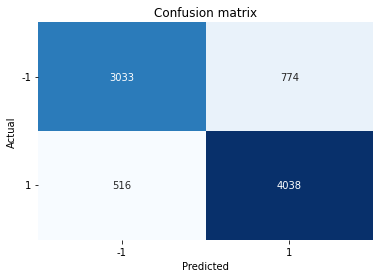

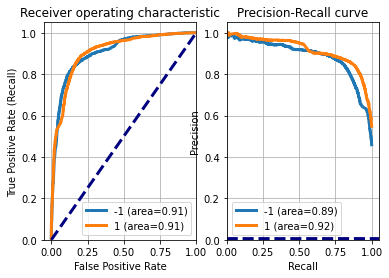

In [25]:
classes = np.unique(y_test2)
y_test_array = pd.get_dummies(y_test2, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test2, y_pred)
fscore = metrics.f1_score(y_test2, y_pred, average='macro')
auc = metrics.roc_auc_score(y_test2, predicted_prob1[:, 1]
                            )
prec=metrics.precision_score(y_test2, y_pred,average='macro')
rec = metrics.recall_score(y_test2, y_pred, average='macro')
print("Accuracy:",  round(accuracy,2))
print("macro F1:",  round(fscore,2))
print("Auc:", round(auc,2))
print("Recall:", round(rec,2))
print("Precission:", round(prec,2))
print("Detail:")

accs.append(accuracy)
f1scores.append(fscore)
precissions.append(prec)
recalls.append(rec)
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test2, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=classes,
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],
                                             predicted_prob1[:,i])
    ax[0].plot(fpr, tpr, lw=3,
               label='{0} (area={1:0.2f})'.format(classes[i],
                                                  metrics.auc(fpr, tpr))
               )

ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05],
          xlabel='False Positive Rate',
          ylabel="True Positive Rate (Recall)",
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test_array[:,i], predicted_prob1[:,i])
    ax[1].plot(recall, precision, lw=3,
               label='{0} (area={1:0.2f})'.format(classes[i],
                                                  metrics.auc(recall, precision))
               )
ax[1].plot(thresholds, color='navy', lw=3, linestyle='--')  
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall',
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()


# Naive Bayes

Accuracy: 0.82
macro F1: 0.81
Auc: 0.9
Recall: 0.82
Precission: 0.81
Detail:


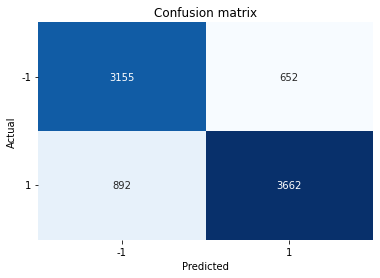

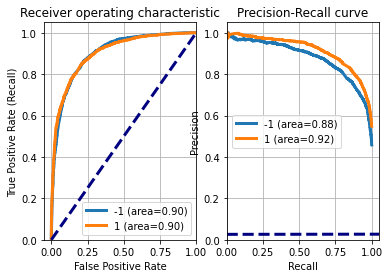

In [26]:
classes = np.unique(y_test2)
y_test_array = pd.get_dummies(y_test2, drop_first=False).values
# y_pred2 = clf2.predict(X_test2)
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test2, y_pred2)
fscore = metrics.f1_score(y_test2, y_pred2, average='macro')
auc = metrics.roc_auc_score(y_test2, predicted_prob2[:, 1]
                            )
prec=metrics.precision_score(y_test2, y_pred2,average='macro')
rec = metrics.recall_score(y_test2, y_pred2,average='macro')
print("Accuracy:",  round(accuracy,2))
print("macro F1:",  round(fscore,2))
print("Auc:", round(auc,2))
print("Recall:", round(rec,2))
print("Precission:", round(prec,2))
print("Detail:")

accs.append(accuracy)
f1scores.append(fscore)
precissions.append(prec)
recalls.append(rec)
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test2, y_pred2)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=classes,
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],
                                             predicted_prob2[:,i])
    ax[0].plot(fpr, tpr, lw=3,
               label='{0} (area={1:0.2f})'.format(classes[i],
                                                  metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05],
          xlabel='False Positive Rate',
          ylabel="True Positive Rate (Recall)",
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test_array[:,i], predicted_prob2[:,i])
    ax[1].plot(recall, precision, lw=3,
               label='{0} (area={1:0.2f})'.format(classes[i],
                                                  metrics.auc(recall, precision))
               )
ax[1].plot(thresholds, color='navy', lw=3, linestyle='--')  
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall',
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Logistic Regression

Accuracy: 0.85
macro F1: 0.85
Auc: 0.92
Recall: 0.85
Precission: 0.85
Detail:


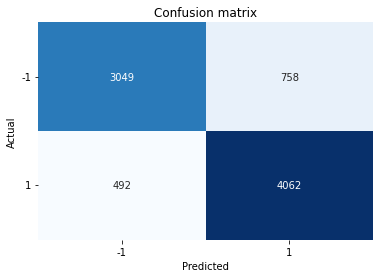

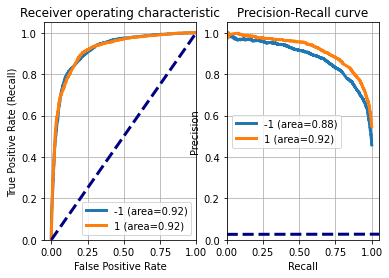

In [27]:
classes = np.unique(y_test2)
y_test_array = pd.get_dummies(y_test2, drop_first=False).values
# y_pred3 = clf3.predict(X_test2)
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test2, y_pred3)
fscore = metrics.f1_score(y_test2, y_pred3, average='macro')
auc = metrics.roc_auc_score(y_test2, predicted_prob3[:, 1]
                            )

prec=metrics.precision_score(y_test2, y_pred3,average='macro')
rec = metrics.recall_score(y_test2, y_pred3,average='macro')
print("Accuracy:",  round(accuracy,2))
print("macro F1:",  round(fscore,2))
print("Auc:", round(auc,2))
print("Recall:", round(rec,2))
print("Precission:", round(prec,2))
print("Detail:")

accs.append(accuracy)
f1scores.append(fscore)
precissions.append(prec)
recalls.append(rec)
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test2, y_pred3)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=classes,
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],
                                             predicted_prob3[:,i])
    ax[0].plot(fpr, tpr, lw=3,
               label='{0} (area={1:0.2f})'.format(classes[i],
                                                  metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05],
          xlabel='False Positive Rate',
          ylabel="True Positive Rate (Recall)",
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test_array[:,i], predicted_prob2[:,i])
    ax[1].plot(recall, precision, lw=3,
               label='{0} (area={1:0.2f})'.format(classes[i],
                                                  metrics.auc(recall, precision))
               )
ax[1].plot(thresholds, color='navy', lw=3, linestyle='--')  
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall',
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [28]:

info = {'Models': ['SVM RBF', 'Naive Bayes', 'Logistic Regression'], 'macro-F1 scores': f1scores, 'avg Accuracies': accs,
       'Precision':precissions,'Recall':recalls}
print(tabulate(info,headers='keys',tablefmt='fancy_grid',showindex=True))

╒════╤═════════════════════╤═══════════════════╤══════════════════╤═════════════╤══════════╕
│    │ Models              │   macro-F1 scores │   avg Accuracies │   Precision │   Recall │
╞════╪═════════════════════╪═══════════════════╪══════════════════╪═════════════╪══════════╡
│  0 │ SVM RBF             │          0.84345  │         0.845712 │    0.84688  │ 0.841692 │
├────┼─────────────────────┼───────────────────┼──────────────────┼─────────────┼──────────┤
│  1 │ Naive Bayes         │          0.814652 │         0.815333 │    0.814227 │ 0.816432 │
├────┼─────────────────────┼───────────────────┼──────────────────┼─────────────┼──────────┤
│  2 │ Logistic Regression │          0.848269 │         0.850496 │    0.851897 │ 0.846428 │
╘════╧═════════════════════╧═══════════════════╧══════════════════╧═════════════╧══════════╛


Ας δούμε τις αποδόσεις σε unknown/unseen Data

In [29]:
#read the test csv file
dataTest = pd.read_csv(r"Covid19sentimentAnalysis/Datasets/Corona_NLP_test.csv", encoding='ansi')
dataTest["Sentiment"] = dataTest["Sentiment"].replace('Extremely Negative', 'Negative', regex=True)

dataTest["Sentiment"] = dataTest["Sentiment"].replace('Extremely Positive', 'Positive', regex=True)
dataTest["Sentiment"]=dataTest["Sentiment"].replace('Negative', -1, regex=True)
dataTest["Sentiment"]=dataTest["Sentiment"].replace('Positive', 1, regex=True)
dataTest["Sentiment"]=dataTest["Sentiment"].replace('Neutral', 0, regex=True)

dataTest = dataTest[dataTest["Sentiment"] != 0]
dataTest.reset_index(drop=True, inplace=True)
# Y = data["Sentiment"]
#to lower case
dataTest["OriginalTweet"] = dataTest["OriginalTweet"].apply(lambda x: lookup_dict(x,emoticons))

dataTest['OriginalTweet']=dataTest['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict1))
dataTest['OriginalTweet']=dataTest['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict2))

dataTest['OriginalTweet'] = dataTest['OriginalTweet'].apply(lambda x: ''.join(''.join(s)[:2] for _, s in itertools.groupby(x)))


#to lower case
dataTest['OriginalTweet']  = dataTest['OriginalTweet'].str.lower()

#remove numbers
dataTest["OriginalTweet"] = dataTest["OriginalTweet"].replace('[0-9]', '', regex=True)

#remove mentions
dataTest["OriginalTweet"] = dataTest["OriginalTweet"].replace('@([a-zA-Z0-9_]{1,50})', '', regex=True)

#remove hashtags
dataTest["OriginalTweet"] = dataTest["OriginalTweet"].replace('#', '', regex=True)

#remove urls
dataTest["OriginalTweet"] = dataTest["OriginalTweet"].replace('http\S+', '', regex=True)

# # #remove all remaining bad chars
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace('[^\\w\\s]', '', regex=True)

dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("Â", "", regex=True)
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("â", "a", regex=True)
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("nz", "", regex=True)
dataTest['OriginalTweet']  = dataTest['OriginalTweet'].str.strip()


dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("_", "", regex=True)
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("   ", " ", regex=True)
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("  ", " ", regex=True)
dataTest['OriginalTweet']  = dataTest['OriginalTweet'].str.strip()
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("coronavir¼", "coronavirus", regex=True)
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("pmmodi", "", regex=True)
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("amp", "and", regex=True)
dataTest["OriginalTweet"]=dataTest["OriginalTweet"].fillna(0)

dataTest['OriginalTweet']  = dataTest['OriginalTweet'].str.strip()
#Tokenize the tweets
tokenized_tweets = dataTest["OriginalTweet"].apply(lambda x: x.split())

#remove stopword(for example and,to at etc)
stop_words = set(stopwords.words('english'))
tokenized_tweets = tokenized_tweets.apply(lambda x: [word for word in x if not word in stop_words])

# stemmer = PorterStemmer()#language='english'
# tokenized_tweets= tokenized_tweets.apply(lambda x: [stemmer.stem(i) for i in x])

lemmatizer = WordNetLemmatizer()
tokenized_tweets = tokenized_tweets.apply(lambda x: [lemmatizer.lemmatize(i,get_pos( i )) for i in x])

tokenized_tweets = tokenized_tweets.apply(lambda x: [word for word in x if len(word)>2 or word=='go'])
# tokenized_tweets= tokenized_tweets.apply(lambda x: [stemmer.stem(i) for i in x])

#Joining the tokenized tweets
for i in range(len(tokenized_tweets)):
    tokenized_tweets[i] = ' '.join(tokenized_tweets[i])
dataTest["OriginalTweet"] = tokenized_tweets


dataTest['OriginalTweet']=dataTest['OriginalTweet'].apply(lambda x:lookup_dict(x,myOwnStopWords))
all_words = []
for line in list(dataTest['OriginalTweet']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())


dataTest["OriginalTweet"]=dataTest["OriginalTweet"].replace("  ", " ", regex=True)

tfidf= tfidf_vectorizer.transform(dataTest["OriginalTweet"])


SVM
Accuracy: 0.8081157596728531
              precision    recall  f1-score   support

          -1       0.79      0.83      0.81      1553
           1       0.83      0.79      0.81      1626

    accuracy                           0.81      3179
   macro avg       0.81      0.81      0.81      3179
weighted avg       0.81      0.81      0.81      3179

Duration: 2.773893117904663
NB
Accuracy: 0.8011953444479396
              precision    recall  f1-score   support

          -1       0.83      0.79      0.81      1701
           1       0.77      0.81      0.79      1478

    accuracy                           0.80      3179
   macro avg       0.80      0.80      0.80      3179
weighted avg       0.80      0.80      0.80      3179

Duration: 0.0008728504180908203
LR
Accuracy: 0.8235294117647058
              precision    recall  f1-score   support

          -1       0.80      0.85      0.82      1550
           1       0.85      0.80      0.82      1629

    accuracy             

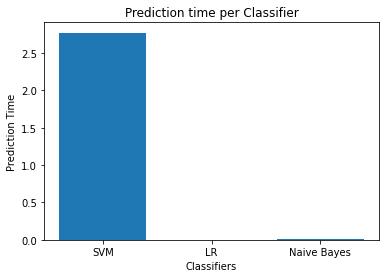

In [30]:
start = time.time()
y_pred= clf1.predict(tfidf)
probas = clf1.predict_proba(tfidf)
duration = time.time() - start
print("SVM")
print("Accuracy:",metrics.accuracy_score(dataTest["Sentiment"], y_pred))
print(metrics.classification_report(y_pred,dataTest["Sentiment"]))
print("Duration: "+str(duration))

start2 = time.time()
y_pred2= clf2.predict(tfidf)
duration2 = time.time() - start2
print("NB")
print("Accuracy:",metrics.accuracy_score(dataTest["Sentiment"], y_pred2))
print(metrics.classification_report(y_pred2,dataTest["Sentiment"]))
print("Duration: "+str(duration2))

start3 = time.time()
y_pred3= clf3.predict(tfidf)
probas3 = clf3.predict_proba(tfidf)
probs=list()
for i in probas3:
    probs.append(np.max(i))
# print(probs)
duration3 = time.time() - start3
print("LR")
print("Accuracy:",metrics.accuracy_score(dataTest["Sentiment"], y_pred3))
print(metrics.classification_report(y_pred3,dataTest["Sentiment"]))
print("Duration: "+str(duration3))

durations = [duration,duration2,duration3]
models = ['SVM', 'LR','Naive Bayes']

plt.bar(models, durations)

plt.xlabel('Classifiers')

plt.ylabel('Prediction Time')
 
plt.title('Prediction time per Classifier')
 
plt.show()

# For LR

In [32]:
tsne = TSNE(n_components=2,learning_rate='auto',init='random')
# pca= PCA(n_components=1)
X_embedded  = tsne.fit_transform(tfidf)
df = pd.DataFrame(columns=['tsne_1','tsne_2','probas','tweet','Sentiment'])
df['tsne_1'] = X_embedded[:, 0]
# df['pca'] = X_embedded[:, 0]
df['tsne_2'] = X_embedded[:, 1]
df['probas'] = pd.DataFrame(probas3)
df['tweet'] = dataTest['OriginalTweet']
df['Sentiment'] = dataTest['Sentiment']
    # print(df.shape)
    # print(df['tsne_1'].head(2))
fig = px.scatter(df, x='probas', y='tsne_1', hover_name= 'tweet',color='Sentiment',size_max=45
                     , template='plotly_white', title='unigram-Bigram similarity and frequency per Sentiment from LR', labels={'words': 'Avg. Length<BR>(words)'}
                     , color_continuous_scale=px.colors.sequential.Sunsetdark)
fig.update_traces(marker=dict(line=dict(width=1, color='Gray')))
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
# fig.show()

iplot(fig)
# fig.write_html('scatterBinary.html')

[**click here to see the scatter plot**](https://htmlpreview.github.io/?https://github.com/icsd13152/Sentiment_Analysis_Covid19/blob/main/scatterBinary.html)
